In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

from vit_prisma.utils.constants import BASE_DIR, DATA_DIR, MODEL_DIR, DEVICE, MODEL_CHECKPOINTS_DIR
from vit_prisma.utils.tutorial_utils import calculate_clean_accuracy, load_clip_models, plot_image, get_feature_activations
from vit_prisma.utils.data_utils.loader import load_dataset
from vit_prisma.sae.config import VisionModelSAERunnerConfig
from vit_prisma.sae.train_sae import VisionSAETrainer
from vit_prisma.utils.tutorial_utils import plot_act_distribution
from vit_prisma.utils.tutorial_utils import plot_top_imgs_for_features

# Prisma SAE Tutorial

This tutorial is a quick start guide on how to load, evaluate, and train SAEs with Prisma. It uses ImageNet as an extended example.



# Setup

Ensure you have ImageNet data locally (you will need to have a Kaggle account).

```
python3 -m venv myenv
source myenv/bin/activate
pip install -e .
pip install kaggle
cd data
kaggle competitions download -c imagenet-object-localization-challenge
```

In [ ]:
DEVICE = 'cuda' # change to cpu if cpu only paradigm
BATCH_SIZE = 16

## Loading pre-trained SAE

Prisma has trained several SAEs for different architectures that can be found on HuggingFace [here](https://huggingface.co/Prisma-Multimodal). Here we will use a CLIP SAE trained on ImageNet. 

In [ ]:
# Load an SAE
from huggingface_hub import hf_hub_download, list_repo_files
from vit_prisma.sae import SparseAutoencoder

def load_sae(repo_id, file_name, config_name):
    # Step 1: Download SAE from Hugginface
    sae_path = hf_hub_download(repo_id, file_name) # Download weights
    hf_hub_download(repo_id, config_name) # Download config

    # Step 2: Load the pretrained SAE weights from the downloaded path
    print(f"Loading SAE from {sae_path}...")
    sae = SparseAutoencoder.load_from_pretrained(sae_path) # This now automatically gets config.json and converts into the VisionSAERunnerConfig object
    return sae

repo_id = "Prisma-Multimodal/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-10-hook_mlp_out-l1-1e-05" # Change this to your chosen SAE. See /docs for a list of SAEs.
file_name = "weights.pt" # Usually weights.pt but may have slight naming variation. See the original HF repo for the exact file name
config_name = "config.json"
sae = load_sae(repo_id, file_name, config_name)

Let's look at the sae's config and examine some details. In particular, we confirm that it was trained on the layer 11 residual stream of the base model `open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K`.

In [ ]:

from pprint import pprint
sae.cfg
pprint(sae.cfg)

## Load pretrained model

Let's load the pretrained CLIP model using the `load_hooked_model` function. The function loads the pretrained CLIP weights from Huggingface and puts the weights into our HookedViT object so that we can readily grab the intermediate activations.

In [ ]:
# Load model
from vit_prisma.models.model_loader import load_hooked_model

model_name = sae.cfg.model_name
model = load_hooked_model(model_name)
model.to(DEVICE) # Move to device

## Load dataset

In [ ]:
# Put paths here
from vit_prisma.transforms import get_clip_val_transforms
import torchvision

def load_imagenet(imagenet_validation_path):
    torch.set_grad_enabled(False)


    # Load dataset with CLIP transform
    data_transforms = get_clip_val_transforms()
    val_data = torchvision.datasets.ImageFolder(imagenet_validation_path, transform=data_transforms)

    # We'll also load a version of the dataset without the CLIP transform so that we can visualize it beautifully
    viz_transforms = torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize((224, 224)),
                        torchvision.transforms.ToTensor(),
                    ]
                )
    viz_data = torchvision.datasets.ImageFolder(imagenet_validation_path, transform=viz_transforms)

    # We only want a subset of validation
            
    subset_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # We only want a subset 
    
    return subset_dataloader, val_data, viz_data

# Put your imagenet path here. You can download ImageNet from kaggle.
imagenet_validation_path = '/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/val'
subset_dataloader, subset_dataset, viz_data = load_imagenet(imagenet_validation_path)

## Load classifier

CLIP can work as a zero-shot classifier. Because it learns a joint embedding space for both images and text during pre-training, it can match new images with text descriptions of the classes without requiring any examples of the target classes during inference. Here we load the text embeddings of the class names from file.

So let's load the CLIP classifier for ImageNet.

In [ ]:
classifier_npy_path = '../pretrained_classifiers/clip_benchmark/imagenet_classifier_hf_hub_laion_CLIP_ViT_B_32_DataComp.XL_s13B_b90K.npy'
classifier_class_vectors = np.load(classifier_npy_path)
classifier_class_vectors = torch.from_numpy(classifier_class_vectors).to(DEVICE)

In [ ]:
from tqdm import tqdm
def calculate_clean_accuracy(
    net,
    classifier: torch.Tensor,
    data_loader,
    device=DEVICE,
    top_k: int = 1,
    sae: SparseAutoencoder = None,
):
    """Calculate the top k clean accuracy of a CLIPmodel on a dataset."""

    net.eval()
    correct = 0
    total = 0

    for batch in tqdm(data_loader):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        with torch.no_grad():
            logits = sae.get_test_loss(images, net) if sae else net(images)
            logits = 100.0 * logits @ classifier
            preds = logits.topk(top_k)[1].t()[0]
            correct += preds.eq(labels).sum().item()
            total += len(labels)

            if total > 100: # We'll just check the accuracy on 100 images for brevity.
                break

        torch.cuda.empty_cache()

    accuracy = correct / total if total > 0 else 0
    return accuracy, total

Now let's test the accuracy of CLIP on 50 ImageNet images just as a sanity check! It should be >69%.

In [ ]:

acc, total = calculate_clean_accuracy(model, classifier_class_vectors, subset_dataloader)
print(f"Accuracy is {acc*100}%")

Now we load a particular image to put through the SAE:

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

def plot_image(image, unstandardise=True):
    plt.figure()
    plt.axis("off")

    if unstandardise:
        print("Unstandardizing image")
        get_inverse = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
        )
        image = get_inverse(image)

    image = image.permute(1, 2, 0)
    plt.imshow(image, vmin=-2.5, vmax=2.0)


In [ ]:
# Download both images using wget
!wget -O normal_image.jpg https://raw.githubusercontent.com/Prisma-Multimodal/ViT-Prisma/dev/src/vit_prisma/sample_images/n01818515_39.JPEG


In [ ]:
from PIL import Image
from vit_prisma.transforms import get_clip_val_transforms


img = Image.open("normal_image.jpg").convert()  # Ensure it's 3 channels
transforms = get_clip_val_transforms()
img_tensor = transforms(img)
plot_image(img_tensor.detach().cpu(), unstandardise=False)

Now let's feed the image into an SAE and look at the top-activating features.

In [ ]:
def get_feature_activations(model_input, model, sae):
    # Run the batch through the model to get activations
    _, cache = model.run_with_cache(model_input, names_filter=sae.cfg.hook_point)
    hook_point_activation = cache[sae.cfg.hook_point].to(DEVICE)

    # Calculate the SAE features and stats for the batch
    _, feature_acts, *_ = sae(hook_point_activation)

    return feature_acts


The feature activations are batch x patches x dimensionality. We're just going to grab the first batch and the CLS token (index 0). We'll ignore the spatial patches for now.

In [ ]:
feature_activations = get_feature_activations(img_tensor.to(DEVICE).unsqueeze(0), model, sae)
print(feature_activations.shape)
feature_activations = feature_activations[0,0,:]
print(feature_activations.shape)

In [ ]:
top_indices, _ = plot_act_distribution(
    feature_activations,
    n_top=10
)

In [ ]:
from typing import List, Dict, Tuple, Set, Optional, Union
import einops
import torch
from tqdm import tqdm

@torch.no_grad()
def compute_feature_activations(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    is_cls_list: List[bool],
    top_k: int = 10,
    sampling_type: str = 'max'
) -> Dict[int, Tuple[torch.Tensor, torch.Tensor]]:
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        is_cls_list: Whether to use CLS token activations for each feature
        top_k: Number of top activations to return per feature
        sampling_type: How to sample activations across tokens ('avg' for average)

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
    # Run model and get activations
    _, cache = model.run_with_cache(images, names_filter=[sparse_autoencoder.cfg.hook_point])
    
    layer_activations = cache[sparse_autoencoder.cfg.hook_point]
    batch_size, seq_len, _ = layer_activations.shape

    # Ensure top_k is not greater than batch size
    actual_top_k = min(top_k, batch_size)
    
    # Flatten activations for efficient computation
    flattened_activations = einops.rearrange(layer_activations, "batch seq d_mlp -> (batch seq) d_mlp")
    
    # Compute feature activations using the SAE
    sae_input = flattened_activations - sparse_autoencoder.b_dec
    feature_activations = einops.einsum(sae_input, encoder_weights, "... d_in, d_in n -> ... n") + encoder_biases
    feature_activations = torch.nn.functional.relu(feature_activations)
    
    # Reshape back to batch × seq × features
    reshaped_activations = einops.rearrange(
        feature_activations, 
        "(batch seq) features -> batch seq features", 
        batch=batch_size, 
        seq=seq_len
    )
    
    # Get CLS token activations (first token)
    cls_token_activations = reshaped_activations[:, 0, :]
    
    # Get average activations across tokens if requested
    if sampling_type == 'avg':
        mean_image_activations = reshaped_activations.mean(dim=1)
    elif sampling_type == 'max':
        # Get maximum activation across all tokens for each feature
        mean_image_activations, _ = reshaped_activations.max(dim=1)
    else:
        raise ValueError(f"Invalid sampling type: {sampling_type}, or not implemented yet")

    # Create result dictionary
    top_activations = {}
    
    # For each feature, get top-k activating images
    for feature_idx, (feature_id, is_cls) in enumerate(zip(feature_ids, is_cls_list)):
        if is_cls:
            # Use CLS token activations
            feature_values = cls_token_activations[:, feature_idx]
        else:
            # Use mean activations across tokens
            feature_values = mean_image_activations[:, feature_idx]
        
        # Get top-k values and indices
        top_values, top_indices = feature_values.topk(actual_top_k)
        top_activations[feature_id] = (top_indices, top_values)
    
    return top_activations

def find_top_activations(
    val_dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    interesting_features_indices: List[int],
    is_cls_list: List[bool],
    top_k: int = 16,
    max_samples: int = 50_000,
    batch_size: int = 64, 
    sampling_type: str = 'avg'
) -> Dict[int, Tuple[torch.Tensor, torch.Tensor]]:
    """
    Find the top activations for interesting features across the validation dataset.
    
    Args:
        val_dataloader: DataLoader for validation dataset
        model: Model to analyze
        sparse_autoencoder: Sparse autoencoder
        interesting_features_indices: List of feature indices to analyze
        is_cls_list: Whether to use CLS token for each feature
        top_k: Number of top images to return per feature
        max_samples: Maximum number of samples to process
        batch_size: Batch size for processing
        sampling_type: How to sample activations across tokens
        
    Returns:
        Dictionary mapping feature IDs to tuples of (top_values, top_dataset_indices)
    """
    device = next(model.parameters()).device
    
    # Dictionary to store values and indices for all features
    all_feature_activations = {}
    for feature_id in interesting_features_indices:
        all_feature_activations[feature_id] = {
            'values': [],
            'dataset_indices': []
        }
    
    # Extract weights and biases for relevant features
    encoder_biases = sparse_autoencoder.b_enc[interesting_features_indices]
    encoder_weights = sparse_autoencoder.W_enc[:, interesting_features_indices]

    # Track global dataset indices
    global_idx = 0
    processed_samples = 0
    
    # Process batches
    for batch_idx, (batch_images, batch_labels) in enumerate(tqdm(val_dataloader, total=min(len(val_dataloader), max_samples // batch_size))):
        # Move batch to device
        batch_images = batch_images.to(device)
        current_batch_size = batch_images.shape[0]
        
        # Generate dataset indices for this batch
        batch_dataset_indices = torch.arange(
            global_idx, 
            global_idx + current_batch_size, 
            dtype=torch.long, 
            device=device
        )
        global_idx += current_batch_size
        
        # Get activations for this batch
        batch_activations = compute_feature_activations(
            batch_images, 
            model, 
            sparse_autoencoder, 
            encoder_weights, 
            encoder_biases,
            interesting_features_indices, 
            is_cls_list, 
            top_k=top_k,
            sampling_type=sampling_type
        )

        # For each feature, store values and corresponding dataset indices
        for feature_id in interesting_features_indices:
            # Get top indices and values for this feature in this batch
            batch_top_indices, batch_top_values = batch_activations[feature_id]
            
            # Map batch indices to dataset indices
            dataset_indices = batch_dataset_indices[batch_top_indices]
            
            # Store values and indices
            all_feature_activations[feature_id]['values'].append(batch_top_values)
            all_feature_activations[feature_id]['dataset_indices'].append(dataset_indices)

        # Update processed samples count
        processed_samples += current_batch_size
        if processed_samples >= max_samples:
            break

    # Process all activations to get overall top-k
    final_results = {}
    
    for feature_id in interesting_features_indices:
        # Concatenate all values and indices for this feature
        all_values = torch.cat(all_feature_activations[feature_id]['values']) if all_feature_activations[feature_id]['values'] else torch.tensor([], device=device)
        all_indices = torch.cat(all_feature_activations[feature_id]['dataset_indices']) if all_feature_activations[feature_id]['dataset_indices'] else torch.tensor([], device=device, dtype=torch.long)
        
        # Handle empty case
        if len(all_indices) == 0:
            final_results[feature_id] = (torch.tensor([]), torch.tensor([]))
            continue
        
        # Find unique dataset indices and keep the highest activation per index
        unique_dict = {}
        for i, (val, idx) in enumerate(zip(all_values, all_indices)):
            idx_item = idx.item()
            if idx_item not in unique_dict or val > all_values[unique_dict[idx_item]]:
                unique_dict[idx_item] = i
        
        # Extract unique values and indices
        unique_values = torch.tensor([all_values[i].item() for i in unique_dict.values()], device=device)
        unique_dataset_indices = torch.tensor(list(unique_dict.keys()), device=device, dtype=torch.long)
        
        # Get top-k
        if len(unique_values) > 0:
            k = min(top_k, len(unique_values))
            top_k_values, top_k_idxs = torch.topk(unique_values, k)
            top_dataset_indices = unique_dataset_indices[top_k_idxs]
            
            final_results[feature_id] = (top_k_values.detach().cpu(), top_dataset_indices.detach().cpu())
        else:
            final_results[feature_id] = (torch.tensor([]), torch.tensor([]))

    return final_results

In [ ]:
top_activations_dictionary = find_top_activations(subset_dataloader, model, sae, top_indices, [True]*len(top_indices), batch_size=BATCH_SIZE)

In [57]:
def plot_all_features(top_activations_dict, viz_data, cfg, num_features=None):
    """
    Plot top activating images for all features in the dictionary.
    
    Args:
        top_activations_dict: Dictionary mapping feature_idx to (activation_values, image_indices)
        viz_data: Dataset containing images
        cfg: Configuration object with hook_point
        num_features: Optional limit on number of features to plot (None = all)
    """
    # Sort features by their keys to ensure consistent order
    feature_indices = sorted(top_activations_dict.keys())
    
    # Limit number of features if specified
    if num_features is not None:
        feature_indices = feature_indices[:num_features]
    
    print(f"Plotting {len(feature_indices)} features")
    
    # Plot each feature
    for feature_idx in feature_indices:
        activation_values, imagenet_indices = top_activations_dict[feature_idx]
        
        # Create plot grid
        grid_size = int(np.ceil(np.sqrt(len(imagenet_indices))))
        fig, axs = plt.subplots(int(np.ceil(len(imagenet_indices) / grid_size)), grid_size, figsize=(8, 8))
        fig.suptitle(f"Layer: {cfg.hook_point}, Feature: {feature_idx}")
        
        axs = axs.flatten()
        for i, (image_idx, act_value) in enumerate(zip(imagenet_indices, activation_values)):
            # Get and display image
            image_idx_int = image_idx.item()
            image_tensor = viz_data[image_idx_int][0]  # Assuming viz_data returns (image, _, _)

            
            # Convert to numpy for display
            display = image_tensor.detach().cpu().numpy().transpose(1, 2, 0)

            mean = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
            std = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))
            display = display * std + mean
            
            # Clip values to valid image range [0, 1]
            display = np.clip(display, 0, 1)
            
            axs[i].imshow(display)
            axs[i].set_title(f"Img idx: {image_idx_int} Act: {act_value.item():.3f}")
            axs[i].axis("off")
        
        # Turn off unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis("off")
        
        plt.tight_layout()
        plt.show()
        plt.close() 

Plotting 3 features


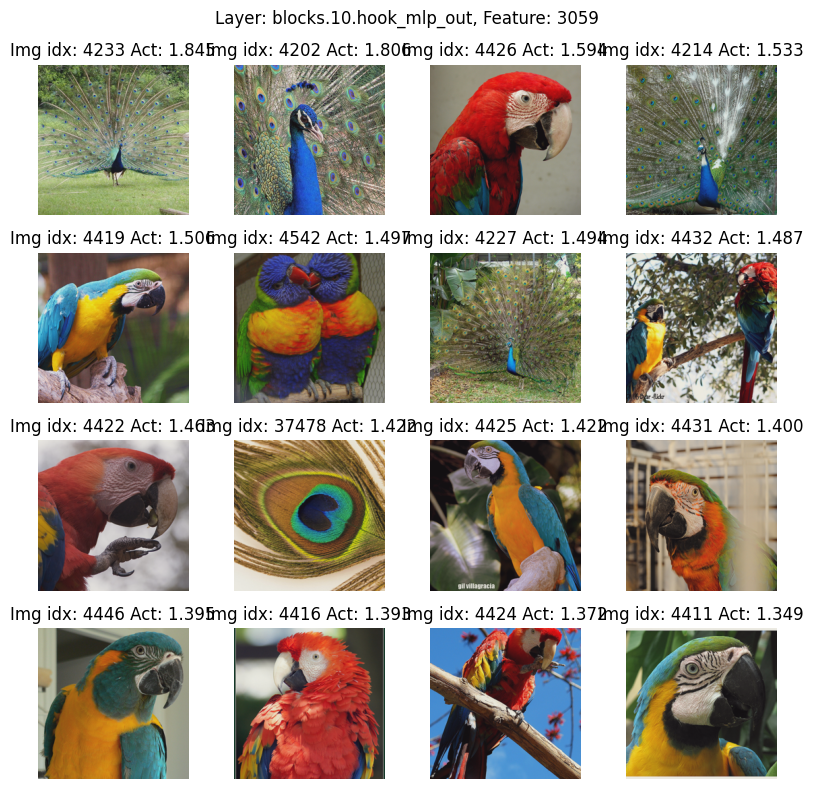

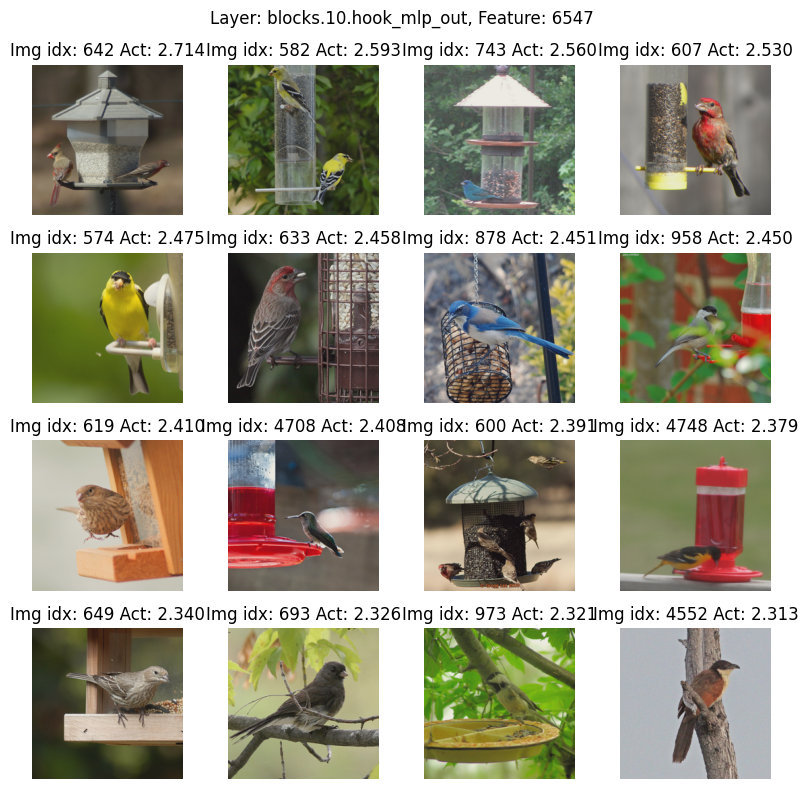

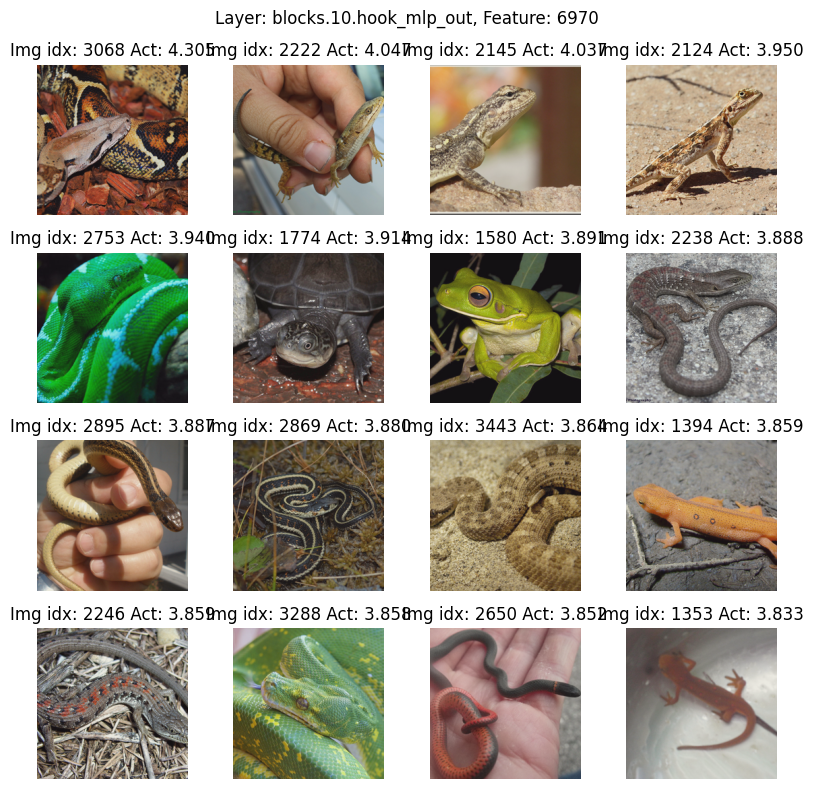

In [58]:
plot_all_features(top_activations_dictionary, subset_dataset, sae.cfg, num_features=3)


# Train an SAE

First we need a model - you can either load one or use Prisma to train:

In [60]:
from vit_prisma.models.base_vit import HookedViT
from vit_prisma.training import trainer


sae_config = VisionModelSAERunnerConfig(
    num_epochs=10,
    n_checkpoints=5,
    log_to_wandb=False,
    verbose=True,
    wandb_log_frequency=1,
    dataset_name="imagenet",
    dataset_path=str(DATA_DIR / "imagenet"),
    train_batch_size=1024,
    hook_point_layer=3,
    device=DEVICE,
    total_training_images=48000,
    total_training_tokens=48000 * 65 * 10,
    model_name="local/imagenet",
    sae_path=str(MODEL_DIR / "sae/imagenet/checkpoints"),
    context_size=65,
    image_size=128,
)

model_function = HookedViT
trainer.train(
    model_function,
    sae_config,
    train_dataset=train_data,
    val_dataset=test_data,
)

TypeError: VisionModelSAERunnerConfig.__init__() got an unexpected keyword argument 'device'

Now we can train the SAE:

In [61]:
sae_train_cfg = VisionModelSAERunnerConfig(
    model_name="local/imagenet",
    hook_point_layer=3,
    d_in=384,
    context_size=65,
    dataset_name="imagenet",
    dataset_path=str(DATA_DIR / "imagenet"),
    dataset_train_path=str(DATA_DIR / "imagenet/ILSVRC/Data/CLS-LOC/train"),
    dataset_val_path=str(DATA_DIR / "imagenet/ILSVRC/Data/CLS-LOC/val"),
    feature_sampling_window=1000,
)

trainer = VisionSAETrainer(sae_train_cfg)
sae = trainer.run()

TypeError: VisionSAETrainer.__init__() missing 2 required positional arguments: 'model' and 'dataset'

# Evaluate the SAE

This notebook is still under development - check back soon!

In [ ]:
evaluator = Evaluator(model, test_data, cfg)
evaluator.evaluate(sae, context=EvaluationContext.POST_TRAINING)